# Imports

In [1]:
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from scipy.io import loadmat
from glob import glob
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from keras.optimizers import Adadelta
from os.path import join

sys.path.append('scripts')
from data_helpers import *
from model_helpers import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
OUT_PATH_MODEL = 'saved'

# Hyperparameters

In [16]:
# Data hyperparameters
ratio_0_1 = 1
excluded_classes = []
target_size = (512, 512)
test_ratio = 0.25
grayscale = False

# Model hyperparameters
mobilenet_width = 1
dense_layers = [128, 64, 32]

# Train hyperparameters
num_epochs = 500
batch_size = 8

# Load data

In [6]:
files = sorted(glob('data/imgs/*jpg'))
labels_data = loadmat('data/imagelabels.mat')['labels'][0].tolist()

unique_labels = set(labels_data)
grouped_files = [[(data[0], data[1]) for data in zip(files, labels_data) if data[1] == label]
                 for label in unique_labels]

same_pairs, diff_pairs, rest_data = create_pairs(grouped_files, ratio_0_1=ratio_0_1)

print('Number of same pairs: {} - Number of different pairs: {}'.format(len(same_pairs), len(diff_pairs)))

Number of same pairs: 2009 - Number of different pairs: 2084


In [7]:
pairs = same_pairs + diff_pairs
file_pairs = [(pair[0][0], pair[1][0]) for pair in pairs]
class_pairs = [(pair[0][1], pair[1][1]) for pair in pairs]
labels = [int(not (pair[0] == pair[1])) for pair in class_pairs]

In [8]:
train_files, test_files, c_train, c_test, y_train, y_test = train_test_split(
        file_pairs, class_pairs, labels, test_size=test_ratio, shuffle=True, stratify=labels)

In [9]:
x_train = create_img_pairs(train_files, 'train', target_size=target_size)
print('Loaded train data!')
x_test = create_img_pairs(test_files, 'test', target_size=target_size)
print('Loaded test data!')

Progressed time: 3.07 sec - ETA: 91.13 sec
Progressed time: 6.02 sec - ETA: 86.37 sec
Progressed time: 8.59 sec - ETA: 79.31 sec
Progressed time: 10.85 sec - ETA: 72.43 sec
Progressed time: 13.09 sec - ETA: 67.24 sec
Progressed time: 15.31 sec - ETA: 63.01 sec
Progressed time: 17.56 sec - ETA: 59.44 sec
Progressed time: 19.83 sec - ETA: 56.23 sec
Progressed time: 22.05 sec - ETA: 53.14 sec
Progressed time: 24.34 sec - ETA: 50.36 sec
Progressed time: 26.61 sec - ETA: 47.62 sec
Progressed time: 28.79 sec - ETA: 44.85 sec
Progressed time: 31.04 sec - ETA: 42.23 sec
Progressed time: 33.24 sec - ETA: 39.63 sec
Progressed time: 35.46 sec - ETA: 37.09 sec
Progressed time: 37.69 sec - ETA: 34.61 sec
Progressed time: 39.95 sec - ETA: 32.17 sec
Progressed time: 42.16 sec - ETA: 29.72 sec
Progressed time: 44.33 sec - ETA: 27.27 sec
Progressed time: 46.53 sec - ETA: 24.87 sec
Progressed time: 48.77 sec - ETA: 22.50 sec
Progressed time: 50.99 sec - ETA: 20.14 sec
Progressed time: 53.18 sec - ETA: 1

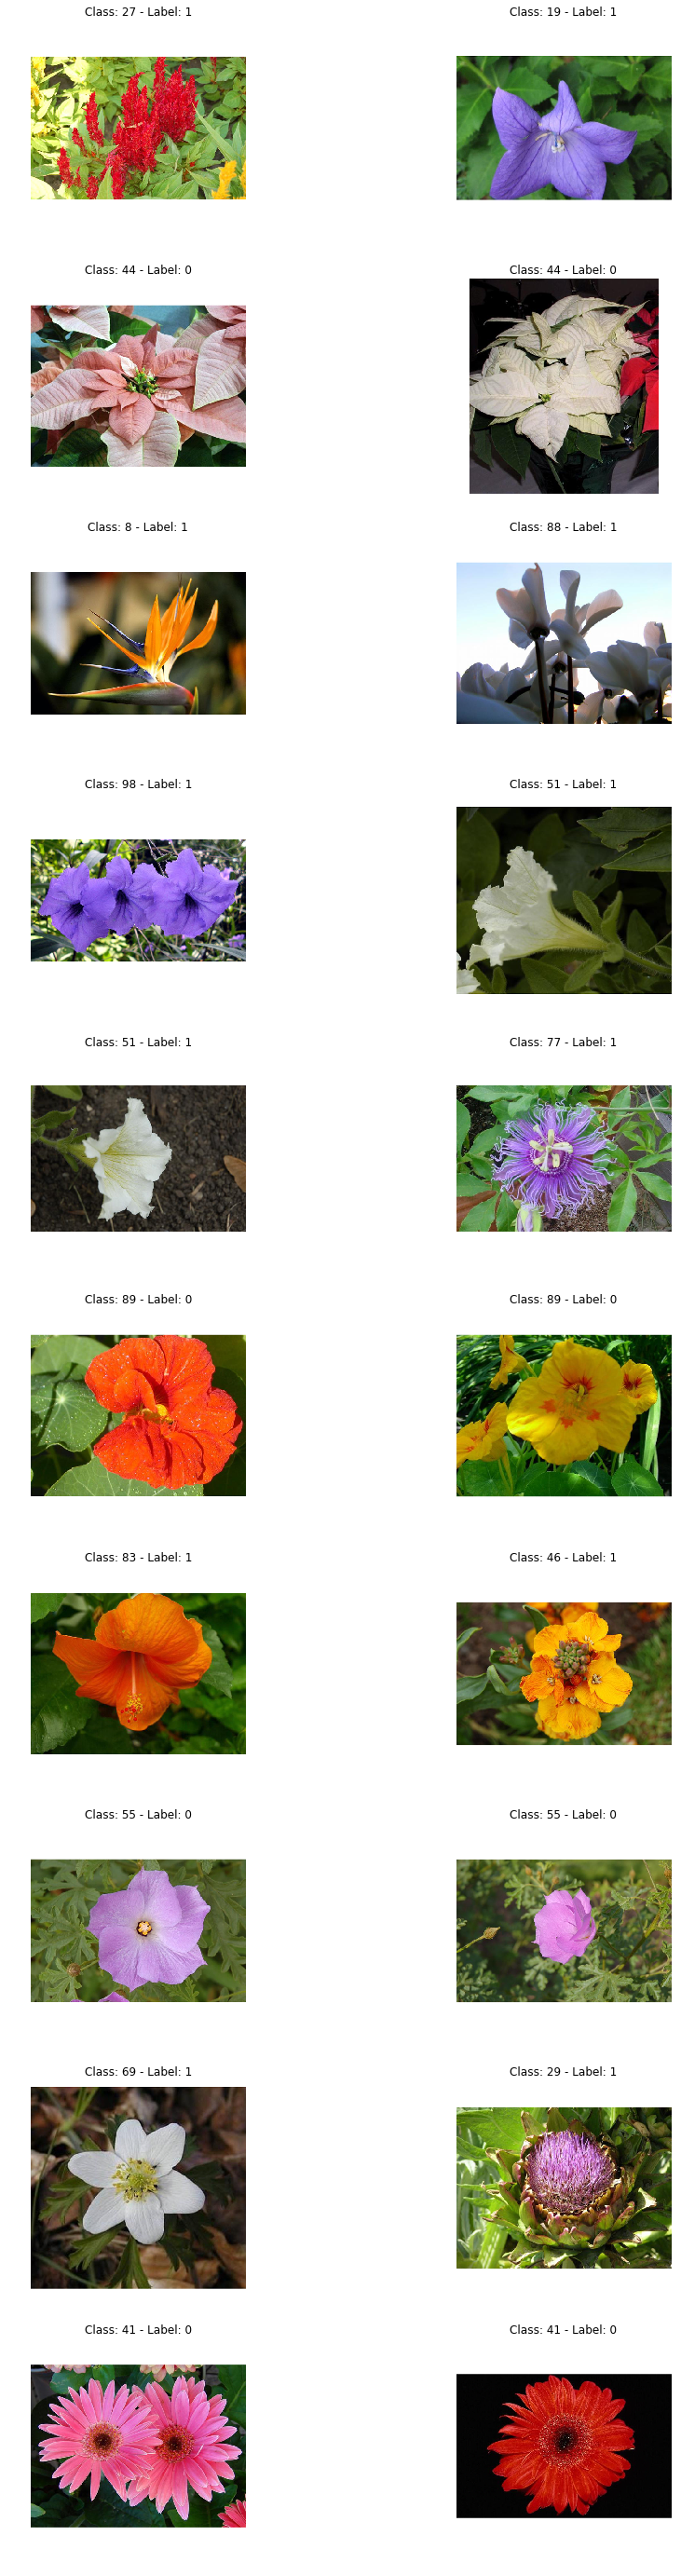

In [10]:
num_vis = 10
fig, ax = plt.subplots(nrows=num_vis, ncols=2, figsize=(15, 50))
for row in range(num_vis):
    for col in range(2):
        ax[row][col].set_title('Class: {} - Label: {}'.format(c_train[row][col], y_train[row]))
        ax[row][col].imshow(x_train[row][col])
        ax[row][col].axis('off')


In [17]:
training_generator = DataGenerator(
    x_train,
    y_train, 
    batch_size=batch_size, 
    augment=True,
    shuffle=True)

# Create callbacks

In [18]:
checkpointer = CustomModelCheckpoint(
    join(OUT_PATH_MODEL, 'logs'), 
    monitor='val_loss', 
    verbose=0, 
    save_weights_only=False, 
    mode='auto', 
    period=1)

tensorboard = TensorBoard(
    log_dir=join(OUT_PATH_MODEL, 'logs'), 
    histogram_freq=0, 
    batch_size=batch_size, 
    write_graph=False, 
    write_grads=False, 
    write_images=False, 
    embeddings_freq=0,
    embeddings_layer_names=None, 
    embeddings_metadata=None, 
    embeddings_data=None)

# Create and compile models

In [13]:
# Create models
encoder = create_mobile_net_encoder((*target_size, 3), dense_layers, mobilenet_width=mobilenet_width)
siamese_model = create_siamese_model(encoder, distance_func=euclidean_distance)
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
first_input (InputLayer)        (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
second_input (InputLayer)       (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32)           2432288     first_input[0][0]                
                                                                 second_input[0][0]               
__________________________________________________________________________________________________
distance (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [14]:
# Compile siamese model
siamese_model.compile(loss=contrastive_loss, optimizer=Adadelta(), metrics=[siamese_accuracy])

# Train model

In [ ]:
# Start training
history_dict = siamese_model.fit_generator(
    generator=training_generator,
    validation_data=(split_imgs(np.array(x_test)), y_test),
    epochs=5,
    verbose=1,
    shuffle=False,
    use_multiprocessing=True,
    workers=10,
    callbacks=[checkpointer, tensorboard])

# Save history
with open(join(OUT_PATH_MODEL, 'history.pkl'), 'wb') as f:
    pickle.dump(history_dict.history, f)

Epoch 1/5
382/383 [============================>.] - ETA: 0s - loss: 0.1552 - siamese_accuracy: 0.5412